In [1]:
import pandas as pd
import numpy as np

In [50]:
train = pd.read_csv("train.csv",dtype = {'Upc': str, 'FinelineNumber':str, 'TripType':"category" , 'Weekday':"category"})
test = pd.read_csv("test.csv",dtype = {'Upc': str, 'FinelineNumber':str, 'TripType':"category" , 'Weekday':"category"})

### Data Preprocess

In [51]:
all_data = pd.concat([train,test])
all_data.reset_index(inplace=True,drop=True)

In [52]:
all_data.drop(['TripType', 'Upc'], axis = 1,inplace = True)

In [53]:
all_data['FinelineNumber_copy'] = all_data['FinelineNumber']

In [54]:
group_visit_fineline = all_data.groupby(['VisitNumber','FinelineNumber'],as_index=False).agg({'FinelineNumber_copy':'count'})

In [55]:
dictVector = []
visitnum = group_visit_fineline['VisitNumber'][1]
visitdict = {}
for i in range(len(group_visit_fineline)):
    if(group_visit_fineline['VisitNumber'][i] == visitnum):
        visitdict[group_visit_fineline['FinelineNumber'][i]] = group_visit_fineline['FinelineNumber_copy'][i]
    else:
        dictVector.append(visitdict)
        visitdict = {}
        visitdict[group_visit_fineline['FinelineNumber'][i]] = group_visit_fineline['FinelineNumber_copy'][i]
        visitnum = group_visit_fineline['VisitNumber'][i]
# Last one
dictVector.append(visitdict)

In [56]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)

In [57]:
X = v.fit_transform(dictVector)

In [58]:
day = pd.get_dummies(all_data[["VisitNumber", "Weekday"]], columns = ["Weekday"])
day = day.drop_duplicates()

# Find unique VisitNumber
uids = group_visit_fineline['VisitNumber'].unique()

# Keep VisitNumber in uids
day = day[day['VisitNumber'].isin(uids)]

In [59]:
day.sort_values(['VisitNumber'], inplace=True)

In [60]:
new_X = np.concatenate((X, day), axis=1)

In [61]:
new_X.shape

(188535, 5361)

In [62]:
t = all_data.groupby(['VisitNumber','DepartmentDescription']).agg({'DepartmentDescription':'count'})

In [63]:
t1 = t.unstack()

In [64]:
t1 = t1['DepartmentDescription']

In [65]:
t1.fillna(0, inplace= True)

In [66]:
dp = []
for i in uids:
    dp.append(list(t1.loc[i]))

In [67]:
department = np.array(dp)
#department.shape (188535, 68)

In [69]:
department[department > 0] = 1

In [70]:
final = np.concatenate((new_X, department), axis=1)
#final.shape (188535, 5429)

In [143]:
subset = []
for i in np.random.randint(len(final), size=15000):
    subset.append(final[i])
subset = np.array(subset)

### Dimension Reduction

#### PCA

In [123]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [144]:
scaler = StandardScaler()#normalize the feature
final_normalized = scaler.fit_transform(subset)  # for each feature, subtract off mean and divide by std dev.

In [145]:
pca1 = PCA(1)
pca1.fit(final_normalized)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [146]:
pca1.explained_variance_ratio_ 

array([ 0.0035246])

#### T-SEN

In [127]:
from sklearn.manifold import TSNE

In [147]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40) 
tsen_2d = tsne.fit_transform(final_normalized)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15000 samples in 5.343s...
[t-SNE] Computed neighbors for 15000 samples in 2235.797s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for

In [148]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')  # prettier plots

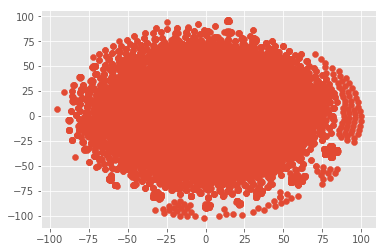

In [149]:
plt.scatter(tsen_2d[:, 0], tsen_2d[:, 1])

### Cluster - GaussianMixture

In [84]:
from sklearn.mixture import GaussianMixture

In [150]:
gmm = GaussianMixture(n_components=5, n_init=100)
gmm.fit(tsen_2d)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=100, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [151]:
gmm_cluster_assignments = gmm.predict(tsen_2d)

In [153]:
gmm_cluster_assignments.shape
gmm_cluster_assignments = gmm_cluster_assignments.reshape((15000, 1))

In [154]:
# Append assignment into original data set
labeled = np.concatenate((subset, gmm_cluster_assignments), axis=1)
labeled.shape

(15000, 5430)

### Classification Model 1: Random Forest

In [155]:
y = labeled[:,-1]
X = labeled[:, 0:5429]

In [156]:
# Split data into train and test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [157]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [209]:
# Preparation for tuning the parameters of random forest
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(10, 110, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 10)]
max_depth.append(None)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=1, n_jobs = -1)
# Fit train data to random forest
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.0min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110], 'max_depth': [10, 14, 18, 23, 27, 32, 36, 41, 45, 50, None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [210]:
rf_random.best_params_

{'max_depth': None, 'n_estimators': 76}

In [211]:
# Predict test data 
pred = rf_random.predict(X_test)

In [212]:
# Evaluate the model 
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, pred)

In [213]:
#Calculate test error
1-(sum(cm.diagonal())/cm.sum())

0.44633333333333336

### Classification Model 2: Adaboost

In [214]:
from sklearn.ensemble import AdaBoostClassifier

In [243]:
ab = AdaBoostClassifier(learning_rate=0.9, n_estimators= 100)
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9, n_estimators=100, random_state=None)

In [244]:
# Predict test data 
pred_ab = ab.predict(X_test)

In [245]:
# Evaluate the model
cm_ab = confusion_matrix(y_test, pred_ab)

In [246]:
#Calculate test error
1-(sum(cm_ab.diagonal())/cm_ab.sum())

0.54600000000000004